# DeepAR on simulation indy500 laptime dataset

laptime dataset
<eventid, carids, laptime (totalcars x totallaps)>

In [1]:
# Third-party imports
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

## Datasets


In [2]:
import pickle
with open('sim-indy500-laptime-2018.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    laptime_data = pickle.load(f, encoding='latin1')

In [3]:
print(f"number of runs: {len(laptime_data)}")

number of runs: 120


To download one of the built-in datasets, simply call get_dataset with one of the above names. GluonTS can re-use the saved dataset so that it does not need to be downloaded again: simply set `regenerate=False`.

In [5]:
laptime_data[2][2].astype(np.float32)

array([[42.3679, 41.0984, 41.0943, ..., 41.5412, 41.3549, 41.7541],
       [43.295 , 41.2297, 41.2107, ...,  0.    ,  0.    ,  0.    ],
       [45.5445, 41.6044, 41.5238, ..., 42.0267, 42.0092, 41.9617],
       ...,
       [45.0093, 45.0862, 42.926 , ..., 42.0984, 41.6441, 41.7593],
       [44.9733, 43.1084, 42.004 , ..., 42.098 , 41.9995, 41.8993],
       [43.7392, 41.1911, 41.799 , ..., 42.2737, 41.967 , 41.8751]],
      dtype=float32)

In [39]:
list(laptime_data[1][1].values())

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32]

In [4]:
from gluonts.dataset.common import ListDataset
prediction_length = 50
freq = "1H"
start = pd.Timestamp("01-01-2019", freq=freq)  # can be different for each time series

train_set = []
test_set = []
cardinality = []
#_data: eventid, carids, laptime array
for _data in laptime_data:
    #_train = [{'target': x.astype(np.float32), 'start': start} 
    #        for x in _data[2][:, :-prediction_length]]
    #_test = [{'target': x.astype(np.float32), 'start': start} 
    #        for x in _data[2]]
    carids = _data[1][1].values()
    _train = [{'target': x.astype(np.float32), 'start': start, 'feat_static_cat': carids} 
            for x in _data[2][:, :-prediction_length]]
    _test = [{'target': x.astype(np.float32), 'start': start, 'feat_static_cat': carids} 
            for x in _data[2]]
    
    train_set.extend(_train)
    test_set.extend(_test)
    cardinality.append(len(carids))




In [5]:
# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
train_ds = ListDataset(train_set, freq=freq)
# test dataset: use the whole dataset, add "target" and "start" fields
test_ds = ListDataset(test_set, freq=freq)

In general, the datasets provided by GluonTS are objects that consists of three main members:

- `dataset.train` is an iterable collection of data entries used for training. Each entry corresponds to one time series
- `dataset.test` is an iterable collection of data entries used for inference. The test dataset is an extended version of the train dataset that contains a window in the end of each time series that was not seen during training. This window has length equal to the recommended prediction length.
- `dataset.metadata` contains metadata of the dataset such as the frequency of the time series, a recommended prediction horizon, associated features, etc.

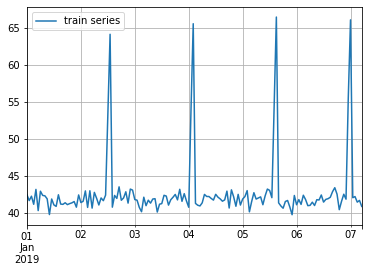

In [6]:
from gluonts.dataset.util import to_pandas
entry = next(iter(train_ds))
train_series = to_pandas(entry)
train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.show()

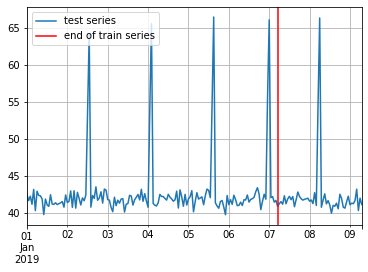

In [7]:
entry = next(iter(test_ds))
test_series = to_pandas(entry)
test_series.plot()
plt.axvline(train_series.index[-1], color='r') # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.show()

In [8]:
print(f"Length of forecasting window in test dataset: {len(test_series) - len(train_series)}")
print(f"Recommended prediction horizon: {prediction_length}")
print(f"Frequency of the time series: {freq}")

Length of forecasting window in test dataset: 50
Recommended prediction horizon: 50
Frequency of the time series: 1H


## Training an existing model (`Estimator`)

GluonTS comes with a number of pre-built models. All the user needs to do is configure some hyperparameters. The existing models focus on (but are not limited to) probabilistic forecasting. Probabilistic forecasts are predictions in the form of a probability distribution, rather than simply a single point estimate.

We will begin with GulonTS's pre-built feedforward neural network estimator, a simple but powerful forecasting model. We will use this model to demonstrate the process of training a model, producing forecasts, and evaluating the results.

GluonTS's built-in feedforward neural network (`SimpleFeedForwardEstimator`) accepts an input window of length `context_length` and predicts the distribution of the values of the subsequent `prediction_length` values. In GluonTS parlance, the feedforward neural network model is an example of `Estimator`. In GluonTS, `Estimator` objects represent a forecasting model as well as details such as its coefficients, weights, etc.

In general, each estimator (pre-built or custom) is configured by a number of hyperparameters that can be either common (but not binding) among all estimators (e.g., the `prediction_length`) or specific for the particular estimator (e.g., number of layers for a neural network or the stride in a CNN).

Finally, each estimator is configured by a `Trainer`, which defines how the model will be trained i.e., the number of epochs, the learning rate, etc.

In [9]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer

INFO:root:Using GPU


In [10]:
estimator = DeepAREstimator(
    prediction_length=prediction_length,
    context_length=100,
    use_feat_static_cat=True,
    cardinality=cardinality,
    freq=freq,
    trainer=Trainer(ctx="gpu", 
                    epochs=100, 
                    learning_rate=1e-3, 
                    num_batches_per_epoch=64
                   )
)

After specifying our estimator with all the necessary hyperparameters we can train it using our training dataset `dataset.train` by invoking the `train` method of the estimator. The training algorithm returns a fitted model (or a `Predictor` in GluonTS parlance) that can be used to construct forecasts.

In [11]:
predictor = estimator.train(train_ds)

INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 64/64 [00:16<00:00,  3.83it/s, avg_epoch_loss=2.71]
INFO:root:Epoch[0] Elapsed time 16.715 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=2.713318
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 64/64 [00:12<00:00,  4.96it/s, avg_epoch_loss=2.03]
INFO:root:Epoch[1] Elapsed time 12.918 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=2.034428
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 64/64 [00:12<00:00,  4.94it/s, avg_epoch_loss=1.92]
INFO:root:Epoch[2] Elapsed time 12.949 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=1.924344
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 64/64 [00:12<00:00,  4.94it/s, avg_epoch_loss=1.94]
INFO:root:Epoch[3] Elapsed time 12.949 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=1.935103
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 64/64 [00:12<00:00,  4.95it/s, avg_epoch_l

INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 64/64 [00:12<00:00,  4.97it/s, avg_epoch_loss=1.79]
INFO:root:Epoch[37] Elapsed time 12.872 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=1.788865
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 64/64 [00:12<00:00,  4.94it/s, avg_epoch_loss=1.8]
INFO:root:Epoch[38] Elapsed time 12.944 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=1.800712
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 64/64 [00:12<00:00,  4.96it/s, avg_epoch_loss=1.79]
INFO:root:Epoch[39] Elapsed time 12.893 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=1.786305
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 64/64 [00:12<00:00,  4.98it/s, avg_epoch_loss=1.77]
INFO:root:Epoch[40] Elapsed time 12.859 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=1.769710
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 64/64 [00:12<00:00,  4.95it/s, avg_epoch_loss=1.76]
INFO:root

With a predictor in hand, we can now predict the last window of the `dataset.test` and evaluate our model's performance.

GluonTS comes with the `make_evaluation_predictions` function that automates the process of prediction and model evaluation. Roughly, this function performs the following steps:

- Removes the final window of length `prediction_length` of the `dataset.test` that we want to predict
- The estimator uses the remaining data to predict (in the form of sample paths) the "future" window that was just removed
- The module outputs the forecast sample paths and the `dataset.test` (as python generator objects)

In [12]:
from gluonts.evaluation.backtest import make_evaluation_predictions

In [13]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

First, we can convert these generators to lists to ease the subsequent computations.

In [14]:
forecasts = list(forecast_it)
tss = list(ts_it)

We can examine the first element of these lists (that corresponds to the first time series of the dataset). Let's start with the list containing the time series, i.e., `tss`. We expect the first entry of `tss` to contain the (target of the) first time series of `dataset.test`.

In [15]:
# first entry of the time series list
ts_entry = tss[0]

In [16]:
len(ts_entry)

200

In [17]:
# first 5 values of the time series (convert from pandas to numpy)
np.array(ts_entry[-10:]).reshape(-1,)

array([41.5407  , 42.300125, 41.14965 , 41.35346 , 41.292854, 41.716145,
       43.252876, 40.36934 , 42.038216, 41.179314], dtype=float32)

In [18]:
# first entry of dataset.test
dataset_test_entry = next(iter(test_ds))

In [19]:
# first 5 values
dataset_test_entry['target'][-10:]

array([41.5407  , 42.300125, 41.14965 , 41.35346 , 41.292854, 41.716145,
       43.252876, 40.36934 , 42.038216, 41.179314], dtype=float32)

In [20]:
len(tss[0])

200

In [3]:
# Indy500 Car 12 WillPower
ts_entry = tss[52]
ts_entry

NameError: name 'tss' is not defined

The entries in the `forecast` list are a bit more complex. They are objects that contain all the sample paths in the form of `numpy.ndarray` with dimension `(num_samples, prediction_length)`, the start date of the forecast, the frequency of the time series, etc. We can access all these information by simply invoking the corresponding attribute of the forecast object.

In [23]:
# first entry of the forecast list
forecast_entry = forecasts[52]

In [24]:
forecast_entry.samples[0,:]

array([42.158695, 43.179485, 42.133892, 44.5483  , 43.362453, 43.71313 ,
       43.37671 , 42.3173  , 43.06187 , 41.976013, 42.99156 , 43.04412 ,
       41.16733 , 43.477287, 43.309208, 43.001003, 42.2888  , 45.117966,
       43.73459 , 42.886765, 43.41842 , 42.906197, 43.080715, 42.908894,
       42.162243, 43.84459 , 45.09659 , 41.697052, 42.66063 , 42.79704 ,
       41.116676, 43.21243 , 43.029743, 44.361904, 44.347202, 43.304195,
       44.27366 , 43.0212  , 43.244846, 44.076767, 44.058327, 41.733643,
       43.51992 , 42.67892 , 43.452263, 42.777397, 44.58146 , 42.04611 ,
       42.036606, 42.30914 ], dtype=float32)

In [25]:
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 100
Dimension of samples: (100, 50)
Start date of the forecast window: 2019-01-07 06:00:00
Frequency of the time series: 1H


We can also do calculations to summarize the sample paths, such computing the mean or a quantile for each of the 48 time steps in the forecast window.

In [26]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Mean of the future window:
 [42.253838 42.406857 42.325737 42.358032 42.620487 42.515087 42.903072
 42.820503 42.6767   42.783134 42.892094 43.045624 42.860073 42.983658
 43.16626  43.136574 43.090134 43.195953 42.915314 42.700443 42.73994
 42.88785  43.266914 42.82445  42.97857  42.857838 43.021538 42.188507
 42.6694   43.24675  42.898537 42.915844 42.84709  43.062057 43.092743
 42.893646 43.02167  43.025623 42.81439  43.16591  43.095055 43.12997
 42.636368 42.46769  42.691776 42.74499  42.683903 42.83849  42.714596
 42.607506]
0.5-quantile (median) of the future window:
 [42.199245 42.30815  42.316063 42.31478  42.57473  42.431267 42.93907
 42.83465  42.827538 42.703793 42.915825 43.04412  42.931667 42.96842
 43.290607 43.132732 43.20366  43.065556 42.850956 42.72324  42.88414
 42.845993 43.30271  42.952633 42.97699  42.751835 43.017254 42.18728
 42.72888  43.38325  42.958744 43.023182 43.019794 43.102932 43.116528
 42.91168  42.971306 43.0212   42.76022  43.109108 43.279133 43.03838

`Forecast` objects have a `plot` method that can summarize the forecast paths as the mean, prediction intervals, etc. The prediction intervals are shaded in different colors as a "fan chart".

In [27]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150 
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

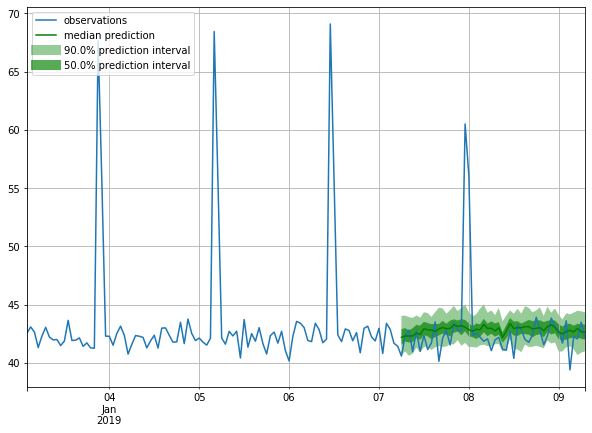

In [28]:
plot_prob_forecasts(ts_entry, forecast_entry)

We can also evaluate the quality of our forecasts numerically. In GluonTS, the `Evaluator` class can compute aggregate performance metrics, as well as metrics per time series (which can be useful for analyzing performance across heterogeneous time series).

In [29]:
from gluonts.evaluation import Evaluator

In [30]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))

Running evaluation: 100%|██████████| 3960/3960 [00:29<00:00, 134.69it/s]


Aggregate metrics aggregate both across time-steps and across time series.

In [31]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 20.36154080585518,
    "abs_error": 346140.7423362732,
    "abs_target_sum": 8510522.005615234,
    "abs_target_mean": 42.98243437179411,
    "seasonal_error": 3.031913744602445,
    "MASE": 0.5759419213585566,
    "sMAPE": 0.03702774465830029,
    "MSIS": 13.99487277443013,
    "QuantileLoss[0.1]": 120847.78777389527,
    "Coverage[0.1]": 0.2826969696969697,
    "QuantileLoss[0.5]": 346140.74265289307,
    "Coverage[0.5]": 0.7374646464646464,
    "QuantileLoss[0.9]": 367558.1781021118,
    "Coverage[0.9]": 0.9261313131313131,
    "RMSE": 4.512376403388261,
    "NRMSE": 0.1049818715328364,
    "ND": 0.040672092981827654,
    "wQuantileLoss[0.1]": 0.014199809094455076,
    "wQuantileLoss[0.5]": 0.040672093019031,
    "wQuantileLoss[0.9]": 0.043188676071761196,
    "mean_wQuantileLoss": 0.032686859395082424,
    "MAE_Coverage": 0.14876430976430974
}


Individual metrics are aggregated only across time-steps.

In [32]:
item_metrics.head()

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,sMAPE,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,NaN,15.275533,77.780525,2118.346680,42.366934,2.790739,0.557419,0.033758,12.238897,24.181662,0.26,77.780525,0.84,78.321673,0.96
1,NaN,16.487853,86.104568,2110.306641,42.206133,2.798099,0.615450,0.037658,13.894376,31.854276,0.40,86.104565,0.92,81.596807,0.96
2,NaN,16.428485,75.469299,2136.522705,42.730454,2.955661,0.510676,0.032140,11.617000,21.620537,0.22,75.469299,0.76,81.343304,0.96
3,NaN,23.663965,97.554909,2160.721680,43.214434,2.666542,0.731696,0.041004,19.308225,31.020592,0.24,97.554916,0.74,114.403182,0.90
4,NaN,25.448552,99.715836,2213.656738,44.273135,3.864950,0.516001,0.040886,12.661133,40.521577,0.38,99.715843,0.80,99.532407,0.92


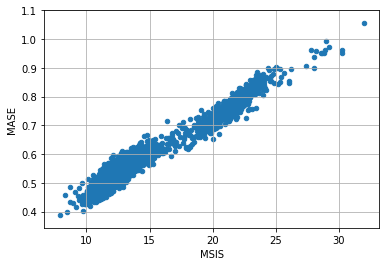

In [33]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()